In [1]:
import svmbir
import tomopy
import math
import dxchange
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import bm3d_streak_removal as bm3d_rmv
from imars3dv2.filters import tilt
# import logging
# logging.basicConfig(level=logging.INFO)

olefile module not found
/home/y9z/anaconda3/envs/tomopy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
def get_ind_list(name_list:list):
    ind = []
    ang_deg = []
    ang_rad = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        _ang = _split[-3] + '.' + _split[-2]
        index = int(_index)
        angle = float(_ang)
        ind.append(index)
        ang_deg.append(angle)
        ang_rad.append(math.radians(angle))
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), (sorted(ang_deg)), np.array(sorted(ang_rad)), ind

def get_list(name_list:list):
    ind = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        index = int(_index)
        ind.append(index)
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), ind

def _init_arr_from_stack(fname, number_of_files, slc=None):
    """
    Initialize numpy array from files in a folder.
    """
    _arr = dxchange.read_tiff(fname, slc)
    size = (number_of_files, _arr.shape[0], _arr.shape[1])
    return np.empty(size, dtype=_arr.dtype)

def read_tiff_stack(fdir, fname:list):
    arr = _init_arr_from_stack(os.path.join(fdir, fname[0]), len(fname))
    for m, name in enumerate(fname):
        arr[m] = dxchange.read_tiff(os.path.join(fdir, name))
    return arr

def find_proj180_ind(ang_list:list):
    dif = [abs(x-180) for x in ang_list]
    difmin = min(dif)
    ind180 = dif.index(difmin)
    return (ind180, ang_list[ind180])

def shrink_window(corners, size):
    corners[0][0] = corners[0][0] + size
    corners[0][1] = corners[0][1] + size
    corners[1][0] = corners[1][0] + size
    corners[1][1] = corners[1][1] - size
    corners[2][0] = corners[2][0] - size
    corners[2][1] = corners[2][1] - size
    corners[3][0] = corners[3][0] - size
    corners[3][1] = corners[3][1] + size
    return corners

def set_roi(corners, xmin, ymin, xmax, ymax):
    corners[0][0] = xmin
    corners[0][1] = ymin
    corners[1][0] = xmin
    corners[1][1] = ymax
    corners[2][0] = xmax
    corners[2][1] = ymax
    corners[3][0] = xmax
    corners[3][1] = ymin
    return corners

In [4]:
###################### need to change start
ipts="27158"
###################### need to change end

# Load CT files

Found index of 180 degree projections:  818
Loading CT projections...
(1637, 2400, 1947)


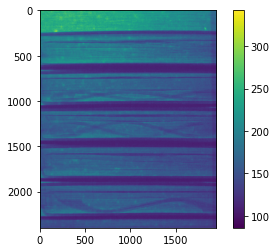

In [5]:
###################### need to change start
ct_scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
###################### need to change end
ct_list = glob.glob(ct_scan_loc+'/raw*')
ct_name, ind_list = get_list(ct_list)
theta = tomopy.angles(len(ind_list), ang1=0, ang2=359.92)
ang_deg = np.rad2deg(theta)
proj180_ind = find_proj180_ind(ang_deg)[0]
print('Found index of 180 degree projections: ', proj180_ind)
print('Loading CT projections...')
proj = read_tiff_stack(fdir=ct_scan_loc, fname=ct_name)
print(proj.shape)
plt.imshow(proj[0])
plt.colorbar()
plt.show()

# Load Open Beam (OB)

Loading Open Beam (OB)...
(1, 2400, 1947)


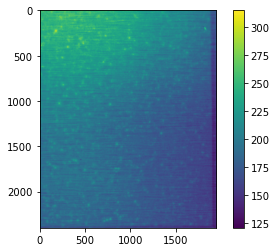

In [6]:
ob_list = glob.glob(ct_scan_loc+'/ob*')
ob_name, ob_ind_list = get_list(ob_list)
print("Loading Open Beam (OB)...")
ob = read_tiff_stack(fdir=ct_scan_loc, fname=ob_name)
print(ob.shape)
plt.imshow(ob[0])
plt.colorbar()
plt.show()

# Load Dark Current (DC)

Loading Dark Current (DC)...
(1, 2400, 1947)


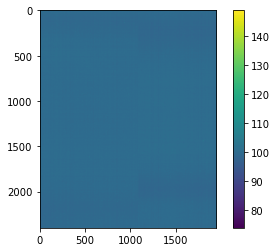

In [7]:
dc_list = glob.glob(ct_scan_loc+'/df*')
dc_name, dc_ind_list = get_list(dc_list)
print("Loading Dark Current (DC)...")
dc = read_tiff_stack(fdir=ct_scan_loc, fname=dc_name)
print(dc.shape)
plt.imshow(dc[0])
plt.colorbar()
plt.show()

# Detect and crop the slits

Projection at 0 degree:


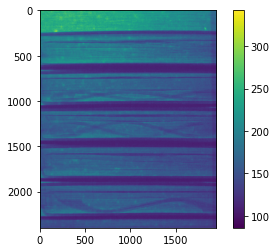

Projection at 180 degree:


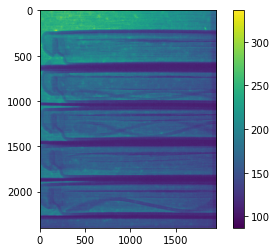

Projection (fliped) at 180 degree:


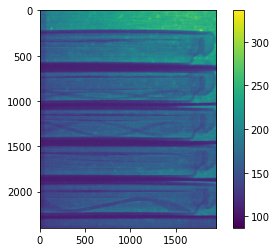

In [8]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob[0], method='simple')
# print("Slit corners: ", slit_box_corners)
# proj = tomopy.prep.alignment.remove_slits_aps_1id(proj, slit_box_corners)
# ob = tomopy.prep.alignment.remove_slits_aps_1id(ob, slit_box_corners)
# dc = tomopy.prep.alignment.remove_slits_aps_1id(dc, slit_box_corners)
print("Projection at 0 degree:")
plt.imshow(proj[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj[proj180_ind])
plt.colorbar()
plt.show()
print("Projection (fliped) at 180 degree:")
plt.imshow(np.fliplr(proj[proj180_ind]))
plt.colorbar()
plt.show()

# Define the ROI

Projection at 0 degree:


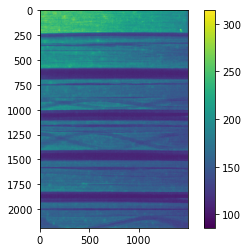

Projection at 180 degree:


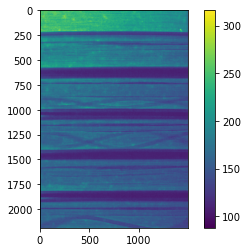

In [9]:
roi_corners = set_roi(corners=slit_box_corners, xmin=400, ymin=0, xmax=1900, ymax=2200)
proj_crop = tomopy.prep.alignment.remove_slits_aps_1id(proj, roi_corners)
ob_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob, roi_corners)
dc_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc, roi_corners)
print("Projection at 0 degree:")
plt.imshow(proj_crop[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_crop[proj180_ind])
plt.colorbar()
plt.show()

# Normalization

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

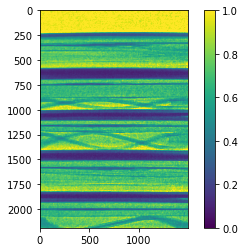

In [10]:
proj_norm = tomopy.normalize(proj_crop, ob_crop, dc_crop)
plt.imshow(proj_norm[0], vmax=1, vmin=0)
plt.colorbar()
plt.show()

# Beam fluctuation correction

In [11]:
# proj_norm = tomopy.prep.normalize.normalize_bg(proj_norm, air=50)
# plt.imshow(proj_norm[0])
# plt.show()

# Filter NaN and negative

In [12]:
proj_norm = tomopy.remove_nan(proj_norm)
proj_norm = tomopy.remove_neg(proj_norm)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integerError.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

# Minus log conversion

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

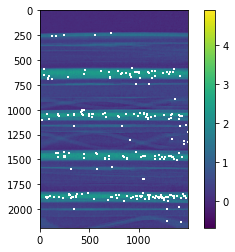

In [13]:
proj_mlog = tomopy.minus_log(proj_norm)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Remove Outliers

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

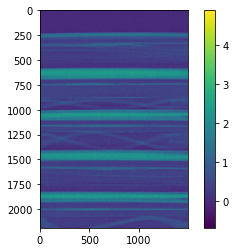

In [14]:
proj_mlog_filter = tomopy.remove_outlier(proj_mlog, 50)
plt.imshow(proj_mlog_filter[0])
plt.colorbar()
plt.show()

# Ring Artifact Removal

Removing rings...
Before ring removal:


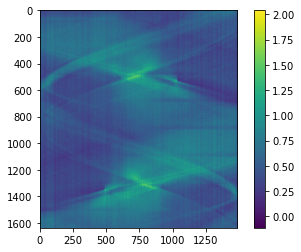

After ring removal:


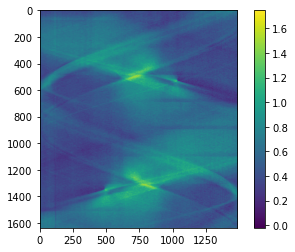

In [15]:
proj_rmv = tomopy.prep.stripe.remove_all_stripe(proj_mlog_filter)
print("Removing rings...")
print("Before ring removal:")
plt.imshow(proj_mlog_filter[:, 400, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, 400, :])
plt.colorbar()
plt.show()

In [ ]:
# bm3d, better, but slow
proj_bm3d_norm = bm3d_rmv.extreme_streak_attenuation(proj_mlog_filter)
proj_bm3d = bm3d_rmv.multiscale_streak_removal(proj_bm3d_norm)
print("Before ring removal:")
plt.imshow(proj_mlog_filter[:, 400, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_bm3d[:, 400, :])
plt.colorbar()
plt.show()

Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 2
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 4
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 9
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 10
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 11
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 12
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 13
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 14
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 15
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 16
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 17
k: 5
k: 4
k: 3

Denoising sinogram 155
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 156
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 157
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 158
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 159
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 160
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 161
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 162
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 163
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 164
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 165
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 166
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 167
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 168
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 169
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 170
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 171
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 172
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 173
k: 5
k: 4
k: 3
k: 2
k: 

# Find and correct tilt

Finding the tilt angle...
Found the tilt angle:  0.04377381694352109


/home/y9z/anaconda3/envs/tomopy/lib/python3.10/site-packages/imars3d-0.1.3-py3.10.egg/imars3dv2/filters/tilt.py:115: TqdmWarning: Iterable length 1637 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  rst = process_map(
Applying tilt corr: 100%|███████████████████████████████████████████████████████████████| 1637/1637 [00:31<00:00, 52.16it/s]


Projection at 0 degree:


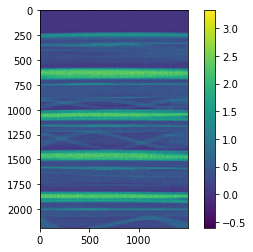

Projection (fliped) at 180 degree:


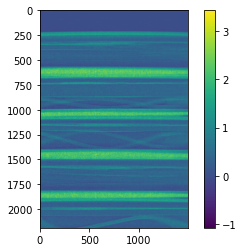

In [16]:
print("Finding the tilt angle...")
tilt_ang = tilt.calculate_tilt(image0=proj_rmv[0], image180=proj_rmv[proj180_ind])
print("Found the tilt angle: ", tilt_ang.x)
# shift = tilt.calculate_shift(reference_image=proj_rmv[0], moving_image=proj_rmv[proj180_ind])
# print("Found the shift: ", shift)
proj_tilt = tilt.apply_tilt_correction(proj_rmv, tilt_ang.x)
print("Projection at 0 degree:")
plt.imshow(proj_tilt[0])
plt.colorbar()
plt.show()
print("Projection (fliped) at 180 degree:")
plt.imshow(np.fliplr(proj_tilt[proj180_ind]))
plt.colorbar()
plt.show()

# Find Center of Rotation

In [17]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_tilt[0,:,:]), np.squeeze(proj_tilt[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation: ', rot_center)
###################### need to change start
rot_center = rot_center + 18
###################### need to change end

Estimated center of rotation:  743.5


# Reconstruction

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

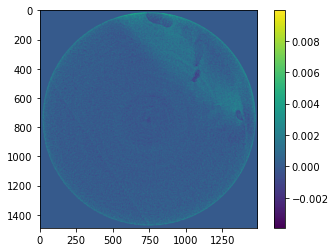

In [40]:
recon = tomopy.recon(proj_tilt, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
recon = tomopy.circ_mask(recon, axis=0, ratio=0.98)
plt.imshow(recon[1666, :, :])
plt.colorbar()
plt.show()

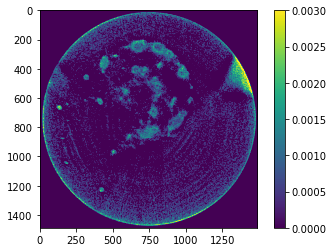

In [25]:
plt.imshow(recon[1225, :, :], vmax=0.003, vmin=0)
plt.colorbar()
plt.show()

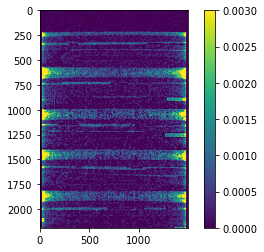

In [46]:
plt.imshow(recon[:, 650, :], vmax=0.003, vmin=0)
plt.colorbar()
plt.show()

# Recon using svMBIR
## Settings for reconstruction
- T, P, sharpness, snr_db: parameters of reconstruction, usually keep fixed. (Can be played with)

In [18]:
T = 2.0
p = 1.2
sharpness = 0.0
snr_db = 30.0
center_offset= -(proj_tilt.shape[2]/2 - rot_center)

In [19]:
recon_mbir = svmbir.recon(proj_tilt, angles=theta, weight_type='transmission', center_offset=center_offset, 
                          snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                          positivity=False, max_iterations=100, num_threads= 112, verbose=0)
# verbose: display of reconstruction: 0 is minimum, 1 is regular

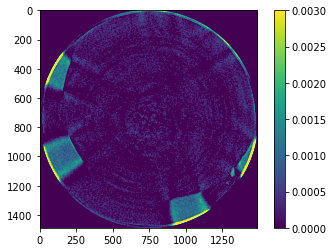

In [49]:
plt.imshow(recon_mbir[950, :, :] , vmax=0.003, vmin=0)
plt.colorbar()
plt.show()

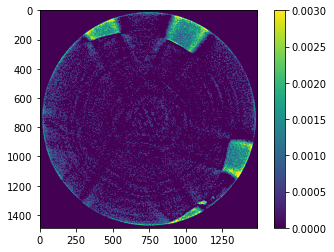

In [48]:
plt.imshow(recon[950, :, :], vmax=0.003, vmin=0)
plt.colorbar()
plt.show()

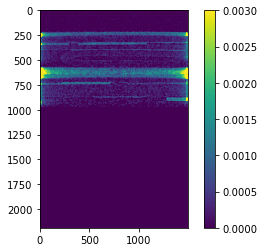

In [47]:
plt.imshow(recon_mbir[:, :, 650] , vmax=0.003, vmin=0)
plt.colorbar()
plt.show()

# Export recon files

In [60]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/stack_ornl"
save_to = "/netdisk/imaging/data_y9z/IPTS-"+ipts+"/stack_ornl/vo_tomopy"

fname = save_to + "/recon"
dxchange.write_tiff_stack(recon, fname=fname, overwrite=True)

PermissionError: [Errno 13] Permission denied: '/netdisk/imaging/data_y9z'

In [59]:
os.listdir("/netdisk/imaging")

['data_hfir',
 'tomo_00001',
 'data_venkat',
 'results',
 'data_az',
 'SNAP_Exp_Aug19',
 'SNAP_temp']

In [65]:
os.listdir("/home/y9z/recon_data/IPTS-27158/stack_ornl/vo_tomopy/")

['recon_00224.tiff',
 'recon_00599.tiff',
 'recon_00004.tiff',
 'recon_00087.tiff',
 'recon_00634.tiff',
 'recon_00433.tiff',
 'recon_00859.tiff',
 'recon_00114.tiff',
 'recon_00030.tiff',
 'recon_00631.tiff',
 'recon_00472.tiff',
 'recon_00789.tiff',
 'recon_00511.tiff',
 'recon_00769.tiff',
 'recon_00001.tiff',
 'recon_00526.tiff',
 'recon_00799.tiff',
 'recon_00905.tiff',
 'recon_00218.tiff',
 'recon_00544.tiff',
 'recon_00002.tiff',
 'recon_00826.tiff',
 'recon_00496.tiff',
 'recon_00396.tiff',
 'recon_00580.tiff',
 'recon_00906.tiff',
 'recon_00895.tiff',
 'recon_00846.tiff',
 'recon_00223.tiff',
 'recon_00652.tiff',
 'recon_00706.tiff',
 'recon_00406.tiff',
 'recon_00036.tiff',
 'recon_00458.tiff',
 'recon_00560.tiff',
 'recon_00712.tiff',
 'recon_00425.tiff',
 'recon_00397.tiff',
 'recon_00669.tiff',
 'recon_00535.tiff',
 'recon_00617.tiff',
 'recon_00823.tiff',
 'recon_00110.tiff',
 'recon_00162.tiff',
 'recon_00044.tiff',
 'recon_00829.tiff',
 'recon_00382.tiff',
 'recon_00773